In [17]:
import os

DATA_FOLDER = os.path.abspath(os.path.join('..', 'data'))
FIGURE_FOLDER = os.path.abspath(os.path.join('..', 'figures'))
MODEL_FOLDER = os.path.abspath(os.path.join('..', 'models'))

notebook_name = '051_run_pep_keras_genomics'

data_folder = os.path.join(DATA_FOLDER, notebook_name)
figure_folder = os.path.join(FIGURE_FOLDER, notebook_name)
model_folder = os.path.join(MODEL_FOLDER, notebook_name)

! mkdir -p $data_folder
! mkdir -p $figure_folder
! mkdir -p $model_folder

model = os.path.join(model_folder, 'model.py')

input_folder = os.path.join(DATA_FOLDER, '023_make_train_valid_test_sets')

In [10]:
ls $DATA_FOLDER/001_amino_acid_encoding

molecular_weight.csv  side_chain_charge.csv  side_chain_polarity.csv
one_hot_encoding.csv  side_chain_class.csv


In [1]:
# from tensorflow.python.client import device_lib ; print(device_lib.list_local_devices())

### Keras-genomics wants mapping files that are tab-separated and have no headers

In [13]:
import glob
import pandas as pd

encoding_folder = os.path.join(DATA_FOLDER, '001_amino_acid_encoding')

for csv in glob.glob(os.path.join(encoding_folder, '*.csv')):
    basename = os.path.basename(csv)
    tsv = os.path.join(data_folder, basename.replace('csv', 'tsv'))
    df = pd.read_csv(csv)
    df.to_csv(tsv, sep='\t', header=False, index=False)
! head $data_folder/*tsv

==> /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/molecular_weight.tsv <==
A	89.094
C	121.154
D	133.10399999999998
E	147.131
F	165.192
G	75.067
H	155.156
I	131.175
K	146.189
L	131.175

==> /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/one_hot_encoding.tsv <==
A	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
C	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
D	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
E	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
F	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
G	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
H	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0
I	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0
K	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0
L	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0

==> /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/side_chain_charge.tsv <==
A	0	1.0	0.0
C	0	1.0	0.0
D	1	0.0	0.0
E	1	0.0	0.0
F	0	1.0	0.0
G	0	1.0	0.0
H	0	0.9	0.1
I	0	1.0	0.0
K	0	0.0	1.0
L	0	1.0	0.0

==> /sr

In [18]:
%%file $model
"""
function (and parameter space) definitions for hyperband
binary classification with Keras (multilayer perceptron)
"""

from __future__ import print_function
from pprint import pprint

from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from keras.callbacks import EarlyStopping
from keras.layers import GlobalMaxPooling2D
from keras.layers.advanced_activations import *
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import Adadelta

from common_defs import *

# a dict with x_train, y_train, x_test, y_test

space = {
    'DROPOUT': hp.choice('drop', (0.1, 0.5, 0.75)),
    'DELTA': hp.choice('delta', (1e-04, 1e-06, 1e-08)),
    'MOMENT': hp.choice('moment', (0.9, 0.99, 0.999)),
}


def get_params():
    params = sample(space)
    return handle_integers(params)


def print_params(params):
    pprint({k: v for k, v in params.items() if not k.startswith('layer_')})
    print()


def try_params(n_iterations, params, data=None, datamode='memory'):
    print("iterations:", n_iterations)
    print_params(params)

    batchsize = 100
    if datamode == 'memory':
        X_train, Y_train = data['train']
        X_valid, Y_valid = data['valid']
        inputshape = X_train.shape[1:]
    else:
        train_generator = data['train']['gen_func'](batchsize,
                                                    data['train']['path'])
        valid_generator = data['valid']['gen_func'](batchsize,
                                                    data['valid']['path'])
        train_epoch_step = data['train']['n_sample'] / batchsize
        valid_epoch_step = data['valid']['n_sample'] / batchsize
        inputshape = \
        data['train']['gen_func'](batchsize, data['train']['path']).next()[
            0].shape[1:]

    model = Sequential()
    model.add(Conv2D(128, (1, 8), padding='same', input_shape=inputshape,
                     activation='relu'))
    model.add(GlobalMaxPooling2D())

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(params['DROPOUT']))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    optim = Adadelta
    myoptimizer = optim(epsilon=params['DELTA'], rho=params['MOMENT'])
    mylossfunc = 'categorical_crossentropy'
    model.compile(loss=mylossfunc, optimizer=myoptimizer, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=0)

    if datamode == 'memory':
        model.fit(
            X_train,
            Y_train,
            batch_size=batchsize,
            epochs=int(round(n_iterations)),
            validation_data=(X_valid, Y_valid),
            callbacks=[early_stopping])
        score, acc = model.evaluate(X_valid, Y_valid)
    else:
        model.fit_generator(
            train_generator,
            steps_per_epoch=train_epoch_step,
            epochs=int(round(n_iterations)),
            validation_data=valid_generator,
            validation_steps=valid_epoch_step,
            callbacks=[early_stopping])
        score, acc = model.evaluate_generator(valid_generator,
                                              steps=valid_epoch_step)

    return {'loss': score, 'model': (
    model.to_json(), optim, myoptimizer.get_config(), mylossfunc)}


Writing /src/myhome/code/sequence-localization/models/051_run_pep_keras_genomics/model.py


In [4]:
import glob


mapperfiles = glob.glob(os.path.join(data_folder, '*tsv'))

dtypes = 'train', 'valid', 'test'
keras_genomics = '/src/myhome/code/Keras-genomics'

seqdata_prefix = 'Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150'

model = os.path.join(model_folder, 'model.py')

for i, mapperfile in enumerate(mapperfiles):
    expt_n = str(i).zfill(2)
#     print(expt_n)
    mapper_prefix = os.path.basename(mapperfile).split('.tsv')[0]
    expt_dir = os.path.join(data_folder, f'pep_expt{expt_n}_{mapper_prefix}')
    print(expt_dir)
    for dtype in dtypes:
        print(f"--- Making {dtype} dataset ... ---")
        input_data = os.path.join(input_folder, f'{seqdata_prefix}.{dtype}')
        target = os.path.join(input_folder, f'{seqdata_prefix}.target.tsv.{dtype}')
        output = os.path.join(expt_dir, f'{dtype}.h5')
        ! python $keras_genomics/embedH5.py --mapperfile $mapperfile $input_data $target $output
    # Run the model
    ! python $keras_genomics/main.py -d $expt_dir -m $model -y -t -e --trainepoch 50

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt00_side_chain_charge
--- Making train dataset ... ---
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
args: Namespace(batch=5000, dataname='data', infile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.train', infile2='', isseq='Y', labelfile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.target.tsv.train', labelname='label', maniprefix='/data', mapperfile='/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/side_chain_charge.tsv', outfile='/src/myhome/code/seq

6300/6300 [==============================] - 1s 139us/step - loss: 0.6755 - acc: 0.6098 - val_loss: 0.6776 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 45us/step

2 seconds.

3 | Wed May 30 19:25:01 2018 | lowest loss so far: 0.6751 (run 2)

iterations: 2.2222222222222223
{'DELTA': 1e-06, 'DROPOUT': 0.1, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 136us/step - loss: 0.7206 - acc: 0.6102 - val_loss: 0.6823 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 47us/step

2 seconds.

4 | Wed May 30 19:25:02 2018 | lowest loss so far: 0.6751 (run 2)

iterations: 2.2222222222222223
{'DELTA': 1e-06, 'DROPOUT': 0.75, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 136us/step - loss: 0.6787 - acc: 0.6125 - val_loss: 0.6770 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 

6300/6300 [==============================] - 0s 57us/step - loss: 0.6671 - acc: 0.6190 - val_loss: 0.6757 - val_acc: 0.5944
Epoch 7/7
900/900 [==============================] - 0s 50us/step

4 seconds.

14 | Wed May 30 19:25:29 2018 | lowest loss so far: 0.6751 (run 2)

iterations: 6.666666666666666
{'DELTA': 0.0001, 'DROPOUT': 0.1, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 206us/step - loss: 0.6851 - acc: 0.6125 - val_loss: 0.6763 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 57us/step - loss: 0.6643 - acc: 0.6200 - val_loss: 0.6761 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 60us/step - loss: 0.6644 - acc: 0.6200 - val_loss: 0.6757 - val_acc: 0.5944
Epoch 4/7
6300/6300 [==============================] - 0s 54us/step - loss: 0.6647 - acc: 0.6200 - val_loss: 0.6766 - val_acc: 0.5944
Epoch 5/7
6300/6300 [==============================] - 0s 59us/st

6300/6300 [==============================] - 0s 53us/step - loss: 0.4496 - categorical_accuracy: 0.7844 - val_loss: 0.8507 - val_categorical_accuracy: 0.5089

Epoch 00015: val_loss did not improve from 0.67491
Test AUC for output neuron 0: 0.4993498913445654
Test categorical accuracy: 0.615
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt01_molecular_weight
--- Making train dataset ... ---
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
args: Namespace(batch=5000, dataname='data', infile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.train', infile2='', isseq='Y', labelfile='/src/myhome/code/sequence-localization/d

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 134us/step - loss: 9.9470 - acc: 0.3827 - val_loss: 9.5813 - val_acc: 0.4056
Epoch 2/2
900/900 [==============================] - 0s 44us/step

2 seconds.

3 | Wed May 30 19:26:23 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.75, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 137us/step - loss: 5.5318 - acc: 0.5873 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 48us/step

2 seconds.

4 | Wed May 30 19:26:25 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 2.2222222222222223
{'DELTA': 0.0001, 'DROPOUT': 0.75, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 144us/step - loss: 6.3259 - acc: 0.5748 - val_loss: 6.5368 - val_acc: 0.5944

900/900 [==============================] - 0s 56us/step

3 seconds.

15 | Wed May 30 19:27:02 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 6.666666666666666
{'DELTA': 1e-08, 'DROPOUT': 0.1, 'MOMENT': 0.99}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 219us/step - loss: 6.2435 - acc: 0.6097 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 56us/step - loss: 6.1212 - acc: 0.6197 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 56us/step - loss: 6.1251 - acc: 0.6198 - val_loss: 6.5368 - val_acc: 0.5944
Epoch 4/7
900/900 [==============================] - 0s 53us/step

3 seconds.

16 | Wed May 30 19:27:05 2018 | lowest loss so far: 6.5368 (run 1)

iterations: 6.666666666666666
{'DELTA': 1e-06, 'DROPOUT': 0.75, 'MOMENT': 0.99}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 

args: Namespace(batch=5000, dataname='data', infile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.test', infile2='', isseq='Y', labelfile='/src/myhome/code/sequence-localization/data/023_make_train_valid_test_sets/Homo_sapiens.GRCh38.pep.all.fa.nuclear_or_cytoplasmic.last150.target.tsv.test', labelname='label', maniprefix='/data', mapperfile='/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/side_chain_polarity.tsv', outfile='/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt02_side_chain_polarity/test.h5')
True
batch_array.shape - before slicing (5000,)
batch_array.shape - after slicing (1800,)
target.shape (1800, 2)
seqs.shape (1800, 2)
data shape:  (1800, 4, 1, 150)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, i

900/900 [==============================] - 0s 47us/step

2 seconds.

8 | Wed May 30 19:27:48 2018 | lowest loss so far: 0.6738 (run 1)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.1, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 157us/step - loss: 0.6715 - acc: 0.6127 - val_loss: 0.6745 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 44us/step

2 seconds.

9 | Wed May 30 19:27:50 2018 | lowest loss so far: 0.6738 (run 1)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.75, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 158us/step - loss: 0.6813 - acc: 0.6111 - val_loss: 0.6756 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 45us/step

2 seconds.

*** 3.0 configurations x 6.7 iterations each

10 | Wed May 30 19:27:52 2018 | lowest loss so far: 0.6738 (run 

6300/6300 [==============================] - 0s 60us/step - loss: 0.6453 - acc: 0.6206 - val_loss: 0.6933 - val_acc: 0.5944
Epoch 6/7
6300/6300 [==============================] - 0s 56us/step - loss: 0.6374 - acc: 0.6275 - val_loss: 0.6719 - val_acc: 0.5956
Epoch 7/7
900/900 [==============================] - 0s 56us/step

4 seconds.

17 | Wed May 30 19:28:17 2018 | lowest loss so far: 0.6738 (run 1)

iterations: 6.666666666666666
{'DELTA': 1e-08, 'DROPOUT': 0.75, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 217us/step - loss: 0.6845 - acc: 0.6068 - val_loss: 0.6755 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 54us/step - loss: 0.6680 - acc: 0.6200 - val_loss: 0.6748 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 59us/step - loss: 0.6685 - acc: 0.6200 - val_loss: 0.6754 - val_acc: 0.5944
Epoch 4/7
6300/6300 [==============================] - 0s 59us/

batch_array.shape - before slicing (5000,)
batch_array.shape - after slicing (1800,)
target.shape (1800, 2)
seqs.shape (1800, 2)
data shape:  (1800, 22, 1, 150)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch1 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch2 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/valid.h5.batch1 ...

*** 9 configurations x 2.2 iterations each

1 | Wed May 30 19:28:44 2018 | lowest loss so far: inf (run -1)

iterations: 2.2222

900/900 [==============================] - 0s 74us/step

3 seconds.

9 | Wed May 30 19:29:07 2018 | lowest loss so far: 0.6735 (run 5)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.75, 'MOMENT': 0.999}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
6300/6300 [==============================] - 1s 210us/step - loss: 0.6764 - acc: 0.6137 - val_loss: 0.6746 - val_acc: 0.5944
Epoch 2/2
900/900 [==============================] - 0s 78us/step

3 seconds.

*** 3.0 configurations x 6.7 iterations each

10 | Wed May 30 19:29:10 2018 | lowest loss so far: 0.6735 (run 5)

iterations: 6.666666666666667
{'DELTA': 1e-06, 'DROPOUT': 0.5, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 213us/step - loss: 0.6709 - acc: 0.6183 - val_loss: 0.6753 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 1s 80us/step - loss: 0.6642 - acc: 0.6200 - val_loss: 0.6806 - val_acc: 0.5944
Epoch 3/7
6

6300/6300 [==============================] - 1s 84us/step - loss: 0.6607 - acc: 0.6206 - val_loss: 0.6733 - val_acc: 0.5944
Epoch 4/7
6300/6300 [==============================] - 1s 84us/step - loss: 0.6574 - acc: 0.6200 - val_loss: 0.6745 - val_acc: 0.5944
Epoch 5/7
6300/6300 [==============================] - 1s 86us/step - loss: 0.6560 - acc: 0.6195 - val_loss: 0.6751 - val_acc: 0.5944
Epoch 6/7
900/900 [==============================] - 0s 84us/step

5 seconds.
{'DELTA': 1e-06, 'DROPOUT': 0.5, 'MOMENT': 0.9}
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch1 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/train.h5.batch2 ...
Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/valid.h5.batch1 ...
Train on 6300 samples, validate on 900 samples
Epoch 1/20
6300/6300 [==============================] 

Reading /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class/valid.h5.batch1 ...

*** 9 configurations x 2.2 iterations each

1 | Wed May 30 19:30:12 2018 | lowest loss so far: inf (run -1)

iterations: 2.2222222222222223
{'DELTA': 1e-08, 'DROPOUT': 0.75, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/2
2018-05-30 19:30:12.763588: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2018-05-30 19:30:13.064487: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 0 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID: 0000:02:00.0
totalMemory: 11.90GiB freeMemory: 11.74GiB
2018-05-30 19:30:13.415618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1356] Found device 1 with properties: 
name: TITAN Xp major: 6 minor: 1 memoryClockRate(GHz): 1.582
pciBusID:

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 203us/step - loss: 0.6728 - acc: 0.6157 - val_loss: 0.6752 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 72us/step - loss: 0.6638 - acc: 0.6200 - val_loss: 0.6831 - val_acc: 0.5944
Epoch 3/7
6300/6300 [==============================] - 0s 72us/step - loss: 0.6632 - acc: 0.6198 - val_loss: 0.6757 - val_acc: 0.5944
Epoch 4/7
900/900 [==============================] - 0s 70us/step

3 seconds.

11 | Wed May 30 19:30:40 2018 | lowest loss so far: 0.6744 (run 4)

iterations: 6.666666666666667
{'DELTA': 1e-06, 'DROPOUT': 0.75, 'MOMENT': 0.9}

Train on 6300 samples, validate on 900 samples
Epoch 1/7
6300/6300 [==============================] - 1s 228us/step - loss: 0.6755 - acc: 0.6148 - val_loss: 0.6754 - val_acc: 0.5944
Epoch 2/7
6300/6300 [==============================] - 0s 71us/step - loss: 0.6673 - acc: 0.6200 - val_loss: 0.6751 - val_acc: 0.5944
Epoch 3

Epoch 2/20
6300/6300 [==============================] - 0s 69us/step - loss: 0.6650 - categorical_accuracy: 0.6200 - val_loss: 0.6757 - val_categorical_accuracy: 0.5944

Epoch 00002: val_loss did not improve from 0.67517
Epoch 3/20
6300/6300 [==============================] - 0s 66us/step - loss: 0.6641 - categorical_accuracy: 0.6203 - val_loss: 0.6779 - val_categorical_accuracy: 0.5944

Epoch 00003: val_loss did not improve from 0.67517
Epoch 4/20
6300/6300 [==============================] - 0s 76us/step - loss: 0.6640 - categorical_accuracy: 0.6179 - val_loss: 0.6794 - val_categorical_accuracy: 0.5944

Epoch 00004: val_loss did not improve from 0.67517
Epoch 5/20
6300/6300 [==============================] - 0s 76us/step - loss: 0.6628 - categorical_accuracy: 0.6151 - val_loss: 0.6751 - val_categorical_accuracy: 0.5944

Epoch 00005: val_loss improved from 0.67517 to 0.67510, saving model to /src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_cl

In [5]:
! ls $data_folder/*expt*

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt00_side_chain_charge:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt01_molecular_weight:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt02_side_chain_polarity:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding:
model		test.txt	 train.h5.batch2  valid.h5.batch1  window8
test.h5.batch1	train.h5.batch1  train.txt	  valid.txt

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class:
model		test.txt	 train.h5.batch2  valid.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

experiments = glob.glob(os.path.join(data_folder, '*expt*'))

dfs = []

for experiment in experiments:

    txt = os.path.join(experiment, 'model', 'model.training_history.txt')
    ! ls $txt
    df = pd.read_table(txt)
    df.columns = df.columns.str.strip('# ')
    print(df.shape)
    df.head()

    reset_index = df.reset_index()
    reset_index = reset_index.rename(columns={'index': 'epoch'})
    reset_index.head()

    tidy = pd.melt(reset_index, id_vars='epoch')
    print(tidy.shape)
    tidy.head()
    
    amino_acid_encoding = '_'.join(os.path.basename(experiment).split('_')[2:])
    print(f'amino_acid_encoding: {amino_acid_encoding}')
    
    tidy['amino_acid_encoding'] = amino_acid_encoding
    dfs.append(tidy)
training_history = pd.concat(dfs, ignore_index=True)

/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt03_one_hot_encoding/model/model.training_history.txt
(20, 4)
(80, 3)
amino_acid_encoding: one_hot_encoding
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt02_side_chain_polarity/model/model.training_history.txt
(17, 4)
(68, 3)
amino_acid_encoding: side_chain_polarity
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt01_molecular_weight/model/model.training_history.txt
(11, 4)
(44, 3)
amino_acid_encoding: molecular_weight
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt00_side_chain_charge/model/model.training_history.txt
(20, 4)
(80, 3)
amino_acid_encoding: side_chain_charge
/src/myhome/code/sequence-localization/data/051_run_pep_keras_genomics/pep_expt04_side_chain_class/model/model.training_history.txt
(13, 4)
(52, 3)
amino_acid_encoding: side_chain_class


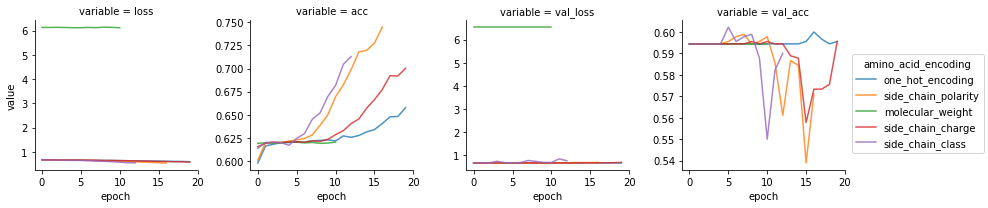

In [16]:
g = sns.FacetGrid(data=training_history, col='variable', hue='amino_acid_encoding', sharey=False)
g.map(plt.plot, 'epoch', 'value', alpha=0.8)
# g.set(ylim=(.4, 1), xlim=(0, 20))
g.add_legend()

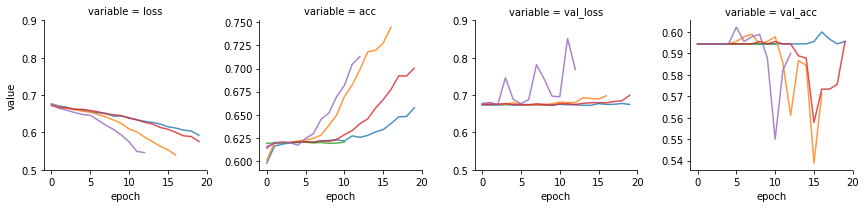

In [15]:
g = sns.FacetGrid(data=training_history, col='variable', hue='amino_acid_encoding', sharey=False)
g.map(plt.plot, 'epoch', 'value', alpha=0.8)
# g.set(ylim=(.4, 1), xlim=(0, 20))
for ax in g.axes.flat:
    if 'loss' in ax.get_title():
        ax.set(ylim=(.5, .9))

In [12]:
ax.get_title() 

'variable = val_acc'

In [21]:
import math

In [22]:
math.factorial(5)

120